In [1]:
%matplotlib inline
import glob
import matplotlib
from matplotlib import pyplot as plt
from zipfile import ZipFile
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [2]:
# General Import
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import cv2
import pathlib
from pathlib import Path

# For modelling
import tensorflow as tf
import keras.callbacks
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model, img_to_array, load_img, array_to_img

#For layering
from keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# For processing
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from tqdm import tqdm

# Evaluation
from sklearn.metrics import classification_report

In [3]:
#device_name = tf.test.gpu_device_name()
#tf.config.experimental.list_physical_devices('GPU')
#tf.config.list_physical_devices('GPU')
#print('GPU activo?', tf.test.is_built_with_cuda())
print(tf.version.VERSION)
#print(f'Nombre GPU: {device_name}')
with tf.device('/CPU:0'):
    print('Using CPU')

2.6.2
Using CPU


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
zip_file_name = './img-classification.zip' #'drive/MyDrive/SistemasInteligentes/img-classification.zip'
with ZipFile(zip_file_name, 'r') as zip:
  zip.extractall()
  print(f'Extracted of "{zip_file_name}"')

Extracted of "./img-classification.zip"


In [6]:
base_dir = './img-classification' #'../input/img-classification/img-classification'
print(os.listdir(base_dir))

train_path, test_path, pred_path = f'{base_dir}/seg_train/', f'{base_dir}/seg_test/', f'{base_dir}/seg_pred/'

['seg_pred', 'seg_test', 'seg_train']


In [7]:
image_train_count = len(list(Path(train_path).glob('*/*.jpg')))
image_test_count = len(list(Path(test_path).glob('*/*.jpg')))
print(f'Train Images: {image_train_count}')
print(f'Test Images: {image_test_count}')

Train Images: 14034
Test Images: 3000


Buildings Images Size: 2191


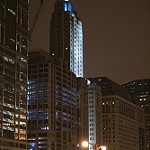

In [8]:
data_dir = Path(train_path)
buildings = list(data_dir.glob('buildings/*'))
print(f'Buildings Images Size: {len(buildings)}')
PIL.Image.open(str(buildings[2190]))

Glaciers Images Size: 2404


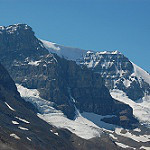

In [9]:
glaciers = list(data_dir.glob('glacier/*'))
print(f'Glaciers Images Size: {len(glaciers)}')
PIL.Image.open(str(glaciers[2158]))

In [10]:
# ordenado alfabeticamente ..
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)
number_classes = len(class_names)
print(f'Images Types: {number_classes}')

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Images Types: 6


In [11]:
print(f'Images in {train_path}')
for folder in os.listdir(train_path):
    idx = class_labels[folder]
    files_path = os.path.join(train_path, folder)
    num_files = len(os.listdir(files_path))
    print(f'{class_names[idx].capitalize()}: {num_files} images')

Images in ./img-classification/seg_train/
Buildings: 2191 images
Forest: 2271 images
Glacier: 2404 images
Mountain: 2512 images
Sea: 2274 images
Street: 2382 images


In [12]:
# define load_dataset function to load dataset with labels
IMAGE_SIZE = (150, 150)

def load_dataset():
    # create list of datasets
    datasets = [train_path, test_path]
    output = []

    for dataset in datasets:
        images = []
        labels = []
        print(f'Loading {dataset}')
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                # resize images
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                images.append(image_file)
                labels.append(label)
                
        # convert the images and labels list to numpy array
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        print('Images file have been loaded')
                
    return output 

In [13]:
# load the data using above functions
(train_X, train_Y), (test_X, test_Y) = load_dataset()

Loading ./img-classification/seg_train/


100%|██████████| 2382/2382 [00:09<00:00, 244.20it/s]


Images file have been loaded
Loading ./img-classification/seg_test/


100%|██████████| 501/501 [00:02<00:00, 230.03it/s]


Images file have been loaded


In [14]:
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (14034, 150, 150, 3) (14034,)
Testing data shape :  (3000, 150, 150, 3) (3000,)


In [15]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs: ', nClasses)
print('Output classes: ', classes)

Total number of outputs:  6
Output classes:  [0 1 2 3 4 5]


In [16]:
# shuffle the train and test datasets
(train_images, train_labels) = shuffle(train_X, train_Y, random_state=0)
(test_images, test_labels) = shuffle(test_X, test_Y, random_state=0)

In [17]:
# normalize the images dataset
train_images = train_images / 255.0
test_images = test_images / 255.0

In [18]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0. 0.]


In [19]:
# Split train and test
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

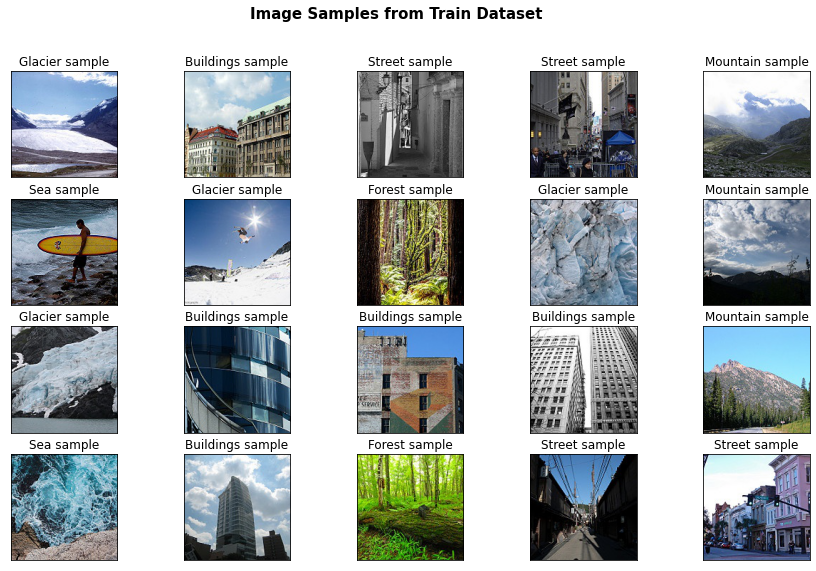

In [20]:
# plot 20 image samples from train dataset
plt.figure(figsize=(15, 9))
plt.suptitle(f'Image Samples from Train Dataset', size=15, weight='bold')
for idx, label in enumerate(train_labels[:20]):
    plt.subplot(4, 5, idx+1)
    plt.imshow(train_images[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{class_names[label].capitalize()} sample')
plt.show()

In [21]:
#with tf.device('/GPU:0'):
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2,2), padding='same'))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2,2), padding='same'))
model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2,2), padding='same'))
model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), padding='same'))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.Dense(number_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 128)       7

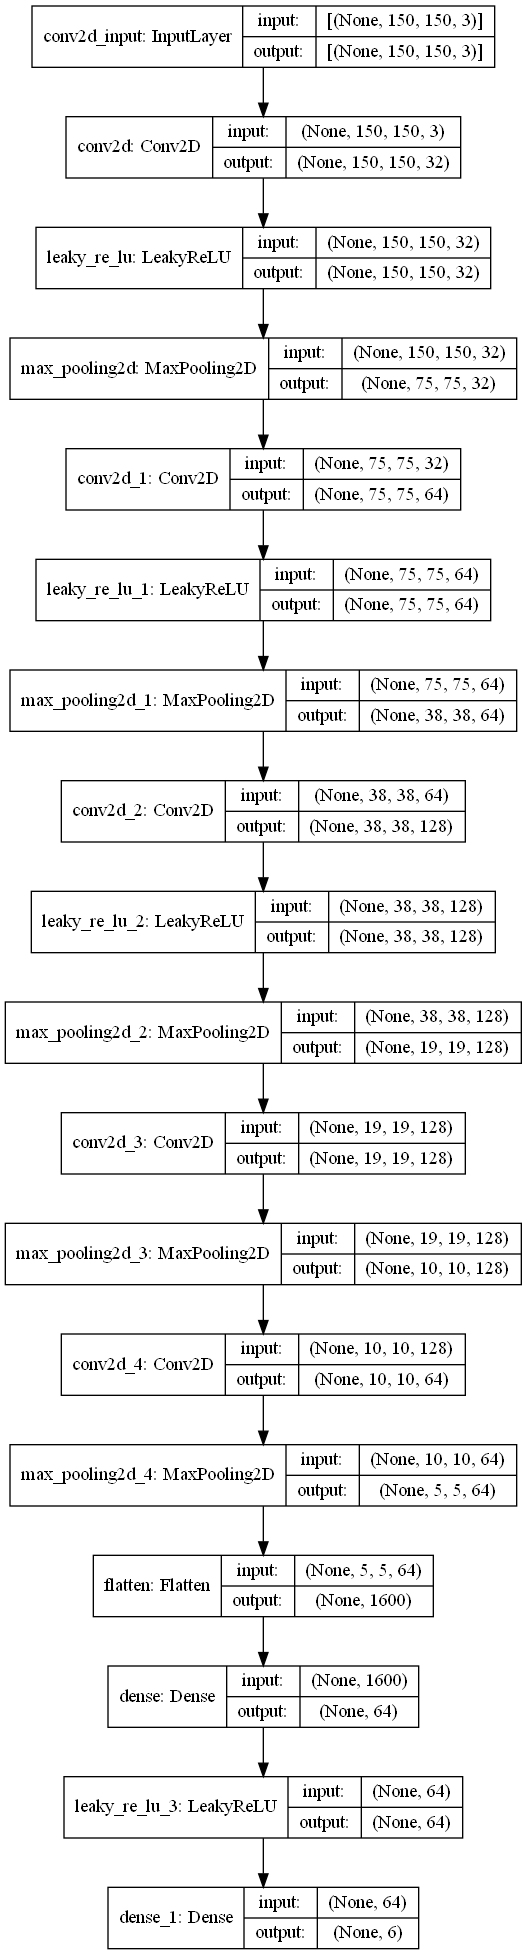

In [22]:
# plot the model algorithm
plot_model(model, to_file='model.png', show_shapes=True)

In [23]:
# compile the model with Adam optimizer
model.compile(loss = categorical_crossentropy,
              optimizer = Adam(),
              metrics=['accuracy'])

In [24]:
batch_size = 128
epochs = 10

In [26]:
# fit model to the data
with tf.device('/CPU:0'):
    history = model.fit(train_X, train_label,
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=1,
                        validation_data = (valid_X, valid_label))

Epoch 1/10
88/88 [==============================] - 175s 2s/step - loss: 3.7724 - accuracy: 0.4758 - val_loss: 0.9533 - val_accuracy: 0.6259
Epoch 2/10
88/88 [==============================] - 209s 2s/step - loss: 0.8589 - accuracy: 0.6702 - val_loss: 0.8162 - val_accuracy: 0.7054
Epoch 3/10
88/88 [==============================] - 210s 2s/step - loss: 0.7484 - accuracy: 0.7178 - val_loss: 0.7266 - val_accuracy: 0.7421
Epoch 4/10
88/88 [==============================] - 229s 3s/step - loss: 0.6317 - accuracy: 0.7694 - val_loss: 0.6989 - val_accuracy: 0.7581
Epoch 5/10
88/88 [==============================] - 217s 2s/step - loss: 0.5462 - accuracy: 0.8042 - val_loss: 0.6359 - val_accuracy: 0.7798
Epoch 6/10
88/88 [==============================] - 218s 2s/step - loss: 0.5090 - accuracy: 0.8162 - val_loss: 0.5893 - val_accuracy: 0.7966
Epoch 7/10
88/88 [==============================] - 225s 3s/step - loss: 0.4233 - accuracy: 0.8479 - val_loss: 0.5683 - val_accuracy: 0.8058
Epoch 8/10
88

In [27]:
# evaluate the model
test_loss, test_acc = model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('test loss and accuracy:', test_loss, test_acc)

test loss and accuracy: 0.5397233366966248 0.8116666674613953


In [28]:
#saving model
model.save('my-model.h5')

In [29]:
def graph_loss_in_epochs(history, save_image_filename, title):
    training_loss = history.history['loss']
    test_loss = history.history['val_loss'] #[10 9 8 5 6 7] 3
    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1) #[1 2 3 4 5 6]
    # Visualize loss history
    plt.title(title)
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(save_image_filename) 
    plt.axvline(x = epoch_count[test_loss.index(min(test_loss))], color = 'c', linestyle="dotted")
    plt.show()

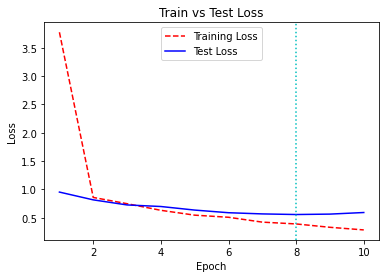

In [30]:
graph_loss_in_epochs(history, 'train_vs_test_loss.png', 'Train vs Test Loss')

In [31]:
# Defining accuracy and loss plot funtion
def plot_loss_accuracy(history, len_epochs):
  epochs = len_epochs
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, 'r--', label='Training Accuracy')
  plt.plot(epochs_range, val_acc,'b-' , label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, 'r--', label='Training Loss')
  plt.plot(epochs_range, val_loss, 'b-', label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
plt.show()

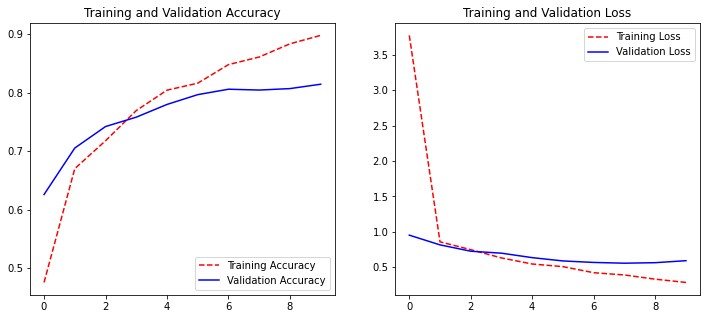

In [33]:
# call the function to plot the curves
plot_loss_accuracy(history, epochs)